##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
#%pip install pandas 
#%pip install matplotlib
#%pip install seaborn
#%pip install scikit-learn
#%pip install geopy
#%pip install category_encoders
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [3]:
###...code...###
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from geopy.geocoders import Nominatim
import math
from category_encoders.binary import BinaryEncoder
import random
import string

# Data Cleaning

In [4]:
def get_random_string():
    return ''.join(random.choice(string.ascii_letters) for i in range(5))

def refreshLocator():
        return Nominatim(user_agent=get_random_string())

geolocator = refreshLocator()

def getCountry(lat, long):
    global geolocator
    if (math.isnan(lat) or math.isnan(long)): return "None"
    try:
        return geolocator \
            .reverse(f"{lat},{long}") \
            .raw['address'] \
            .get('country', '')
    except Exception:
        geolocator = refreshLocator()
        getCountry(lat, long)

In [5]:
# Overview
df_main = pd.read_csv(filepath, encoding='utf-8')
pd.set_option('display.max_columns', None)

# Note: all companies are active
# df_main['Company Status (Active/Inactive)'].unique()

def cleanDf(df_main):
    # Fill NA
    for empty_col in [
        { 'empty': 'Parent Company', 'replacement': 'Company' },
        { 'empty': 'Global Ultimate Company', 'replacement': 'Company' },
        { 'empty': 'Domestic Ultimate Company', 'replacement': 'Company' },
    ]:
        df_main[empty_col['empty']] = df_main[empty_col['empty']].fillna(df_main[empty_col['replacement']])

    emp_regex = re.compile('^Employees')
    for emp_col in [x for x in df_main.columns.values.tolist() if emp_regex.match(x)]:
        df_main[emp_col] = df_main[emp_col].fillna(0)

    for empty_country in ['Parent Country', 'Global Ultimate Country']:
        df_main[empty_country] = df_main[empty_country].fillna(
            getCountry(df_main['LATITUDE'].iloc[0], df_main['LONGITUDE'].iloc[0])
        )

    df_main['Import/Export Status'] = df_main['Import/Export Status'].fillna("None")

    # Sum columns
    if ('Sales (Domestic Ultimate Total USD)' in df_main.columns):
        df_main['Sales (Overall Ultimate Total USD)'] = df_main['Sales (Global Ultimate Total USD)'] + \
            df_main['Sales (Domestic Ultimate Total USD)']
        df_main['Employees (Overall Ultimate Total)'] = df_main['Employees (Domestic Ultimate Total)'] + \
            df_main['Employees (Global Ultimate Total)']
    
    return df_main

df_main = cleanDf(df_main)
# df_main.describe(include='all', datetime_is_numeric=True).transpose()
# df_main.dtypes
# df_main.isnull().any()
# df_main[df_main['Global Ultimate Company'].isnull()]

# Data Visualisation

## Sales

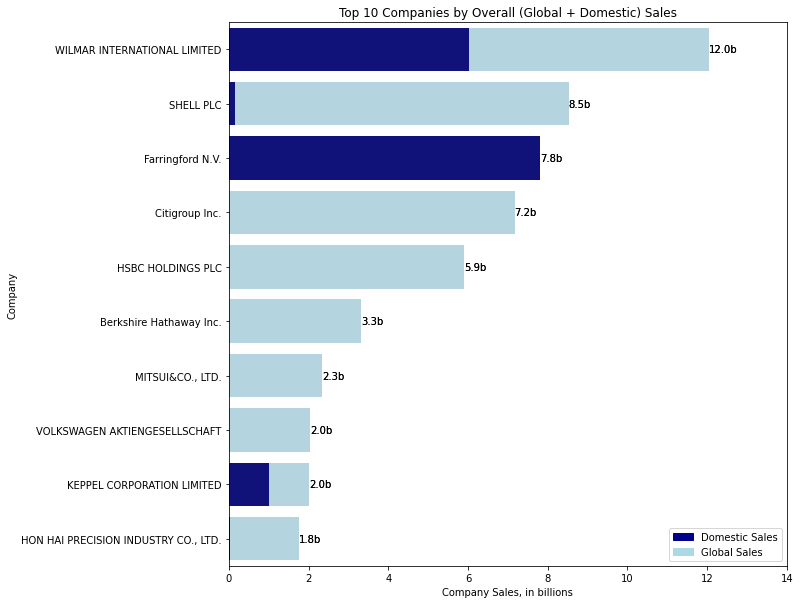

In [6]:
# Note: includes negative sales values
df_companies_sum = df_main \
    .groupby('Global Ultimate Company') \
    .sum() \
    .sort_values(by='Sales (Overall Ultimate Total USD)', ascending=False) \
    .reset_index()

plt.figure(figsize=(10, 10))
NUM_TOP = 10

graph_top = sns.barplot(
    x="Sales (Overall Ultimate Total USD)",
    y="Global Ultimate Company",
    data=df_companies_sum.head(NUM_TOP),
    color='lightblue'
)
graph_bottom = sns.barplot(
    x="Sales (Domestic Ultimate Total USD)",
    y="Global Ultimate Company",
    data=df_companies_sum.head(NUM_TOP),
    color='darkblue'
)

for graph in (graph_top, graph_bottom):
    graph.set_xticks(graph.get_xticks().tolist())
    graph.set_xticklabels(
        ['{:.0f}'.format(x) for x in graph.get_xticks()/1e12]
    )
    
    bars = graph.containers[0]
    graph.bar_label(
        bars,
        labels=[f"{value/1e12:.1f}b" for value in bars.datavalues]
    )

top_bar = mpatches.Patch(color='darkblue', label='Domestic Sales')
bottom_bar = mpatches.Patch(color='lightblue', label='Global Sales')
plt.xlabel("Company Sales, in billions")
plt.ylabel("Company")
plt.title(f"Top {NUM_TOP} Companies by Overall (Global + Domestic) Sales")
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

## Employees

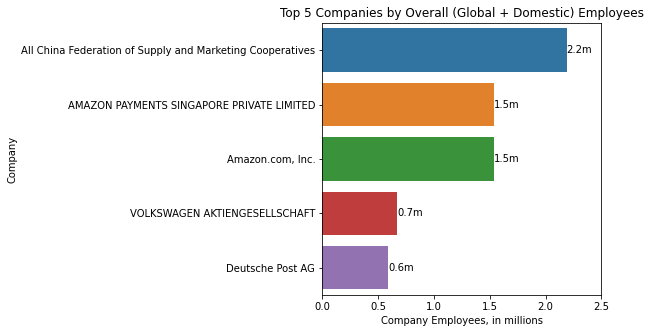

In [7]:
df_companies_avg = df_main \
    .groupby('Global Ultimate Company') \
    .mean() \
    .sort_values(by='Employees (Overall Ultimate Total)', ascending=False) \
    .reset_index() \
    [['Global Ultimate Company', 'Employees (Overall Ultimate Total)']]

plt.figure(figsize=(5, 5))
NUM_TOP = 5

g = sns.barplot(
    x="Employees (Overall Ultimate Total)",
    y="Global Ultimate Company",
    data=df_companies_avg.head(NUM_TOP),
)

g.set_xticks(g.get_xticks().tolist())
g.set_xticklabels(['{:.1f}'.format(x) for x in g.get_xticks()/1e6])

bars = g.containers[0]
g.bar_label(
    bars,
    labels=[f"{value/1e6:.1f}m" for value in bars.datavalues]
)

plt.xlabel("Company Employees, in millions")
plt.ylabel("Company")
plt.title(f"Top {NUM_TOP} Companies by Overall (Global + Domestic) Employees")
plt.show()

## Private vs Public

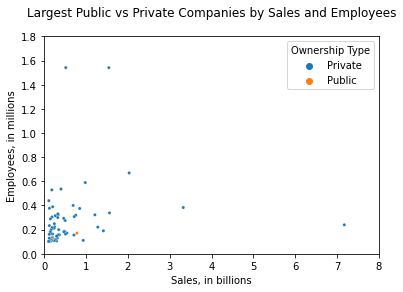

In [8]:
df_private_public = df_companies_sum[['Global Ultimate Company', 'Sales (Overall Ultimate Total USD)']] \
    .join(df_companies_avg.set_index('Global Ultimate Company'), on='Global Ultimate Company') \
    .join(
        df_main[['Global Ultimate Company', 'Ownership Type']].set_index('Global Ultimate Company'),
        on='Global Ultimate Company'
    ).drop_duplicates(subset='Global Ultimate Company')
df_private_public_top = df_private_public[
    (df_private_public['Sales (Overall Ultimate Total USD)'] >= 1e11) &
    (df_private_public['Employees (Overall Ultimate Total)'] >= 1e5)
]

g = sns.scatterplot(
    data=df_private_public_top, 
    x="Sales (Overall Ultimate Total USD)", 
    y="Employees (Overall Ultimate Total)", 
    hue="Ownership Type", 
    s=10
)

g.set_xticks(g.get_xticks().tolist())
g.set_xticklabels(['{:.0f}'.format(x) for x in g.get_xticks()/1e12])
g.set_yticks(g.get_yticks().tolist())
g.set_yticklabels(['{:.1f}'.format(x) for x in g.get_yticks()/1e6])

plt.gca().set_xlim(left=0)
plt.xlabel("Sales, in billions")
plt.ylabel("Employees, in millions")
g.set_title(f"Largest Public vs Private Companies by Sales and Employees", pad=20)
plt.show()

# Modelling

## Preprocessing & Feature Selection

In [9]:
# features = [
#     'Company', 'SIC Code', 'Year Found',
#     'Entity Type', 'Parent Company', 'Parent Country', 'Ownership Type', 'Employees (Single Site)',
#     'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)',
#     'Sales (Domestic Ultimate Total USD)', 'Sales (Global Ultimate Total USD)', 'Import/Export Status',
#     'Fiscal Year End', 'Global Ultimate Company', 'Global Ultimate Country',
#     'Domestic Ultimate Company', 'Is Domestic Ultimate', 'Is Global Ultimate'
# ]

In [10]:
# Encode input
def getTrainInput(df_main):
    encoders = {
        "ohe": {
            "enc": preprocessing.OneHotEncoder(),
            "cols": [
                'Entity Type', 'Ownership Type', 'Import/Export Status',
                'Is Domestic Ultimate', 'Is Global Ultimate',
            ],
        },
        "lb": {
            "enc": BinaryEncoder,
            "cols": [
                'SIC Code', 'Year Found', 'Parent Company', 'Parent Country', 'Fiscal Year End',
                'Global Ultimate Company', 'Global Ultimate Country', 'Domestic Ultimate Company',
            ],
        },
        "mms": {
            "enc": preprocessing.MinMaxScaler(feature_range=(0, 1)),
            "cols": [
                'Employees (Single Site)', 'Employees (Domestic Ultimate Total)',
                'Employees (Global Ultimate Total)', 'Sales (Global Ultimate Total USD)',
            ],
        },
    }
    
    df_train_input = pd.DataFrame()

    for name, encoder in encoders.items():
        if (name == "ohe"):
            encoder['enc'].fit(df_main[encoder['cols']])
            df_train_input = pd.DataFrame(
                encoder['enc'].transform(df_main[encoder['cols']]).toarray(),
                columns=encoder['enc'].get_feature_names()
            )
        elif (name == "lb"):
            encoder['enc'] = encoder['enc'](cols=encoder['cols'])
            df_train_input = pd.concat(
                [df_train_input, encoder['enc'].fit_transform(df_main[encoder['cols']])],
                axis=1
            )
        elif (name == 'mms'):
#             df_train_input = pd.concat(
#                 [pd.DataFrame(
#                     encoder['enc'].fit_transform(df_main[encoder['cols']]),
#                     columns=encoder['cols']
#                 ), df_train_input],
#                 axis=1
#             )
            df_train_input = pd.concat([df_train_input, df_main[encoder['cols']]], axis=1)
    
    return df_train_input

df_train_input = getTrainInput(df_main)

In [11]:
# def getRawOutput(df_main):
#     return df_main['Sales (Domestic Ultimate Total USD)'].to_numpy().reshape(-1, 1)

# def getOutputScaler(raw_output):
#     output_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#     return output_scaler.fit(raw_output)

def getTrainOutput(df_main):
#     return output_scaler.transform(getRawOutput(df_main))
    return df_main['Sales (Domestic Ultimate Total USD)']

def denormaliseOutput(result):
    return result * 1e9

# raw_output = getRawOutput(df_main)
# output_scaler = getOutputScaler(raw_output)
# df_train_output = getTrainOutput(df_main, output_scaler)
df_train_output = getTrainOutput(df_main)

## Building the Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train_input,
    df_train_output,
    test_size=0.2
)

In [13]:
params = {
#     'hidden_layer_sizes': [round((len(X_train.columns)+1)/2),1],
#     'activation': 'relu', 'solver': 'adam',
#     'alpha': 0.0, 'batch_size': 'auto',
#     'random_state': 0, 'tol': 0.000001,
#     'nesterovs_momentum' : False,
#     'learning_rate': 'adaptive',
#     'learning_rate_init': 0.01,
#     'max_iter': 100, 'shuffle': True,
    'n_iter_no_change': 100, 'verbose': False
}

net = MLPRegressor(**params)
net.fit(X_train, y_train.ravel())
# regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
# regr.predict(X_test[:2])
# regr.score(X_val, y_val)

MLPRegressor(n_iter_no_change=100)

In [14]:
result = net.predict(X_test)
net.score(X_test, y_test)

0.0009381799371354083

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [15]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    
    processed_data = cleanDf(hidden_data)
    return net.predict(getTrainInput(processed_data)).tolist()

##### Cell to check testing_hidden_data function

In [16]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[261905.27449109207, 399686672.66649646, 58094.139269329935, 4135674378.959499, 24580.27963824242, 60352.33137940069, 20472712.04249222, 58160.879527211015, 378960855.47999215, 19295192.99448762, 1133750375.6248167, 528129.2223655402, 58096.2292386527, 36099.92374438666, 120999.82340986689, 341899.07236087165, 1050763.2089229834, 26541.07587620722, 25135.58431712048, 35546772.198614135, 40175905.56071327, 1039511.1219275146, 138060.45802623412, 1915193.3768732608, 58083.52195677049, 58338.11948003449, 29654.62871684331, 490897345.7158826, 22005.936920624976, 19144.282794438146, 417660275.0036575, 58152.1867877965, 58056.443918475765, 26756.43920713811, 58087.25065811369, 58868.19666103991, 9833.409348576157, 64787.77095189907, 434018.0897569592, 58197.27364817553, 58087.803615823344, 139085850.75871953, 66448943.199641995, 450483.35916823574, 58141.574091628434, 27229.71403647078, 58173.65527874044, 21869.367745985746, 8673.721612840289, 14329005.921553895, 58156.070424179255, 292621.6

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!